<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Ali Ghasemzadeh</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 401106339</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [1]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [2]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [3]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** PUT YOUR ANSWER HERE :)

If they weren't unifrom some arms become better than others. Intelligent strategies like UCB would identify and exploit high-reward arms, while random or less adaptive agents would incur more regret sampling poorer arms more often.

In [4]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** PUT YOUR ANSWER HERE :)

Binary rewards simplify the problem by modeling each pull as a Bernouli train, this makes the analysis and comparisons more straightforward.

In [5]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [6]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [8]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward = max(p_arr)  # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** PUT YOUR ANSWER HERE :)

The oracle reward shows the upper bound of expected performance if the best arm is always chosen.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** PUT YOUR ANSWER HERE :)

It’s "cheating" because it uses perfect knowledge of probabilities, which isn’t available in real scenarios.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [9]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(self.n_act)  # Placeholder
        return sel_act

In [10]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


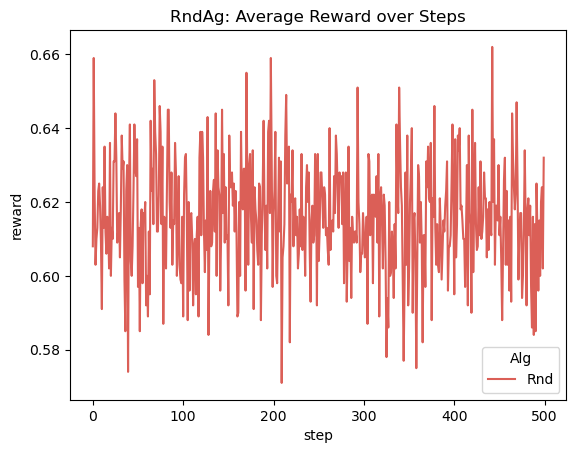

In [11]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** PUT YOUR ANSWER HERE :)

Because it picks arms uniformly without exploiting better arms, its average reward is around the mean of all arms and is highly variable.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** PUT YOUR ANSWER HERE :)

we can choose bias selection toward arms that are known or suspected (from external info) to be better, or cycle systematically through arms instead of pure random.

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


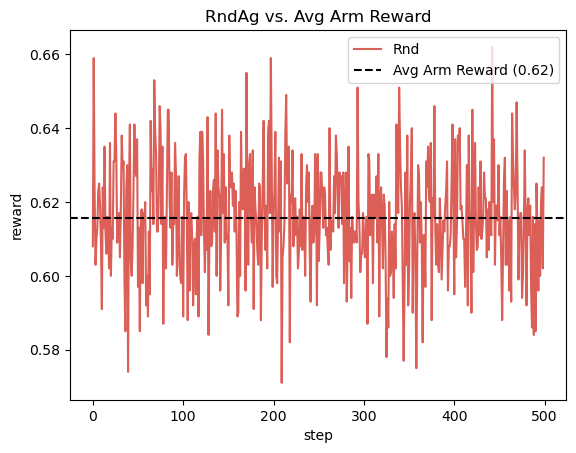

In [41]:
# TODO: Plot RndAg reward curve and average reward of all arms (Simple)
# (Placeholder: just replot RndAg results)
avg_reward = np.mean(p_arr)
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.axhline(avg_reward, color='black', linestyle='--', label=f'Avg Arm Reward ({avg_reward:.2f})')
plt.legend()
plt.title("RndAg vs. Avg Arm Reward")
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [15]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: update Q value (Simple placeholder)
        self.act_counts[act] += 1
        alpha = 1 / self.act_counts[act]
        self.Q[act] += alpha * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        # TODO: Choose random action for t <= max_ex, else best arm [Simple]
        if self.t <= self.max_ex:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = np.argmax(self.Q)
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


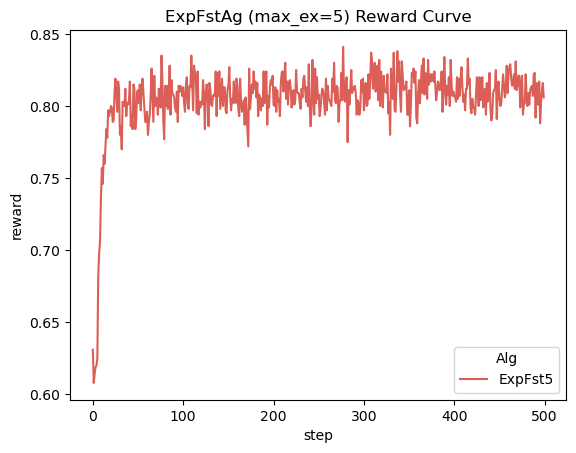

In [16]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** PUT YOUR ANSWER HERE :)

During the early exploration, random pulls cause large reward swings before the agent settles on best arm.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** PUT YOUR ANSWER HERE :)

A fixed exploration window can be too short (missing the best arm) or too long (wasting steps on suboptimal arms).

Alg Sweeps:   0%|          | 0/5 [00:00<?, ?it/s]

Runs:   0%|          | 0/500 [00:00<?, ?it/s]

Runs:   0%|          | 0/500 [00:00<?, ?it/s]

Runs:   0%|          | 0/500 [00:00<?, ?it/s]

Runs:   0%|          | 0/500 [00:00<?, ?it/s]

Runs:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


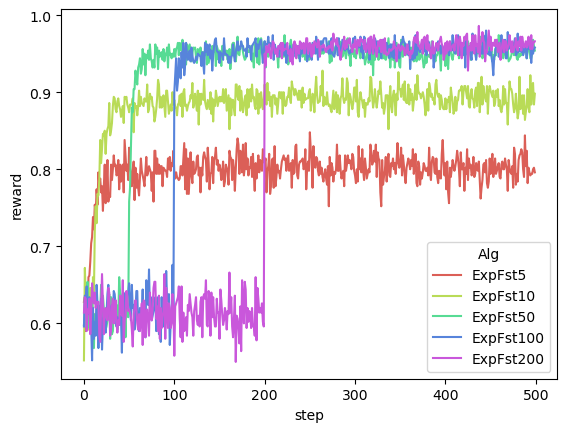

In [ ]:
# TODO: Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] (Simple placeholder)
agents = []
labels = []
for ex in [5, 10, 50, 100, 200]:
    agents.append(ExpFstAg(n_act=nArms, max_ex=ex))
    labels.append(f'ExpFst{ex}')
exp_logs = mab_swp(agents=agents, p_arr=p_arr, labels=labels, n_runs=500, max_steps=500)
plot_logs(exp_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg Reward Curves for Various max_ex")
plt.show()

**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** PUT YOUR ANSWER HERE :)

Longer exploration helps find the best arm more reliably, but delays exploitation, It coverges to higher reward but is slower.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** PUT YOUR ANSWER HERE :)

In practice you may know how many trails you'll get or if condistions change, picking a fixed exploration duration can be difficult.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [22]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: Update Q value (Simple placeholder)
        self.act_counts[act] += 1
        alpha = 1 / self.act_counts[act]
        self.Q[act] += alpha * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # TODO: Compute exploration bonus (Simple placeholder)
        bonus = np.sqrt(2 * np.log(self.t) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


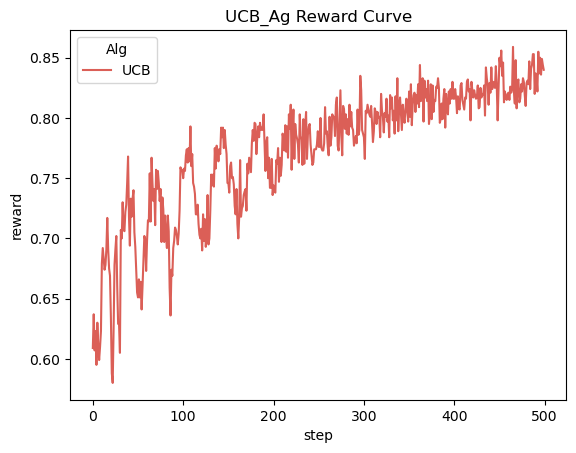

In [23]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

In very short time horizons or rapidly changing environments, a simple fixed exploration phase might outperform UCB if it quickly samples enough to pick the best arm.

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

Algorithms with strong exploration can take longer to exploit but often reach better long-term performance, while simpler strategies can yield faster early rewards but they risk missing the true best arm.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.

UCB remains cautious by adding an exploration bonus and keeps sampling less-explored arms and delays the exploitation leading to slower learning.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running comparison (Simple)...


C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


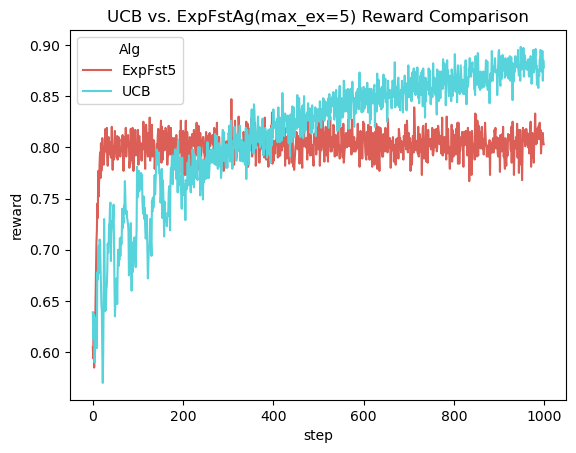

In [31]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)
expfst_logs = mab_swp(agents=[expfst_agent], p_arr=p_arr,labels=['ExpFst5'], n_runs=1000, max_steps=1000)

ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_logs = mab_swp(agents=[ucb_agent], p_arr=p_arr, labels=['UCB'], n_runs=1000, max_steps=1000)
print("Running comparison (Simple)...")

compare_log = pd.concat([expfst_logs, ucb_logs], ignore_index=True)
plot_logs(compare_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg(max_ex=5) Reward Comparison")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

In a very short time horizons or non-stationary environments, a simple fixed exploration window can sometimes outperform UCB by sampling each arms quickly and then exploiting.

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

UCB has conservative exploration bonus so that can slow the short-term performances but for long-terms works better because in the long terms fixed exploration risks missing the true best arm.

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

It overcomes the UCB and find the best arm more quickly and stabilizes at a higher reward sooner than UCB.

Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running comparison (Simple)...


C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


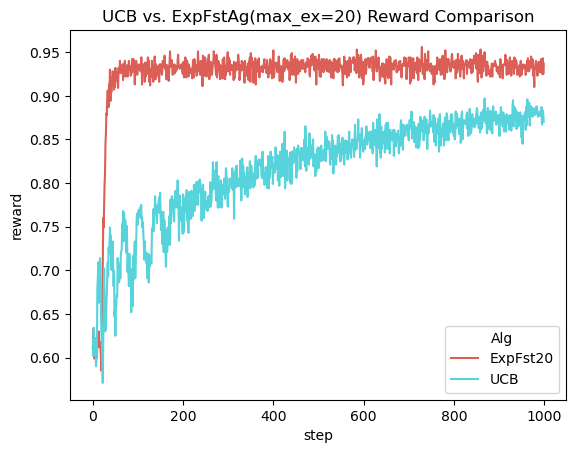

In [30]:
# TODO: Run comparison for ExpFstAg (max_ex=20) and UCB_Ag (Simple placeholder)
print("Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)")
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)
expfst_logs = mab_swp(agents=[expfst_agent], p_arr=p_arr,labels=['ExpFst20'], n_runs=1000, max_steps=1000)

ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_logs = mab_swp(agents=[ucb_agent], p_arr=p_arr, labels=['UCB'], n_runs=1000, max_steps=1000)
print("Running comparison (Simple)...")

compare_log = pd.concat([expfst_logs, ucb_logs], ignore_index=True)
plot_logs(compare_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg(max_ex=20) Reward Comparison")
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** PUT YOUR ANSWER HERE :)

Longer exploration (20 steps) improves estimates of arm rewards, leading to better exploitation later.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** PUT YOUR ANSWER HERE :)

Use empirical testing, tuning, or adaptive methods that monitor performance to adjust exploration-exploitation trade-offs.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** PUT YOUR ANSWER HERE :) (Discuss how hyperparameter tuning and early exploitation can sometimes yield higher rewards in finite-time scenarios.)

Even UCB is asymptotically optimal, its onggoing exploration bonus can delay exploration and with careful selection of hyperparameters, ExpFstAg's fixed shorter exploration phase allows it to exploit high-reward arms sooner and can yield higher rewards in finite-time scenarios.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running skewed arms experiment... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running comparison (Simple)...


C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


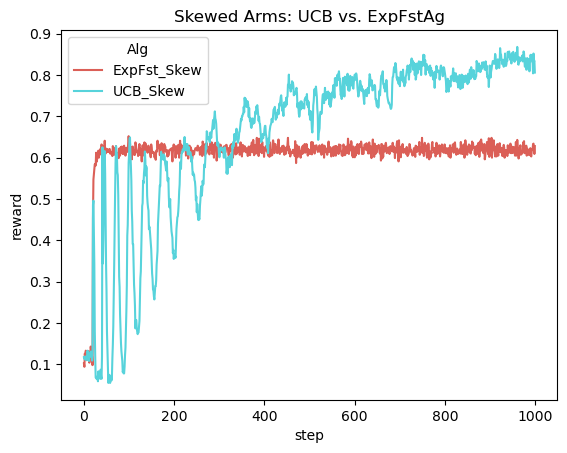

In [35]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# TODO: Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario (Simple placeholder)
print("Running skewed arms experiment... (Simple)")
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))
expfst_logs = mab_swp(agents=[expfst_agent], p_arr=skewed_p, labels=['ExpFst_Skew'], n_runs=1000, max_steps=1000)

ucb_agent = UCB_Ag(n_act=len(skewed_p))
ucb_logs = mab_swp(agents=[ucb_agent], p_arr=skewed_p, labels=['UCB_Skew'], n_runs=1000, max_steps=1000)
print("Running comparison (Simple)...")

compare_log = pd.concat([expfst_logs, ucb_logs], ignore_index=True)
plot_logs(compare_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Skewed Arms: UCB vs. ExpFstAg")
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [42]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # TODO: Choose random action with probability eps [Simple]
        if np.random.random() < self.eps:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** PUT YOUR ANSWER HERE :)

With a high ε, the agent often chooses random arms instead of exploiting the best-known arm, reducing immediate reward.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** PUT YOUR ANSWER HERE :)

Decaying ε over time allows sufficient exploration early on but increases exploitation later, improving long-term performance.

Running EpsGdAg experiments with various eps values... (Simple)


Alg Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


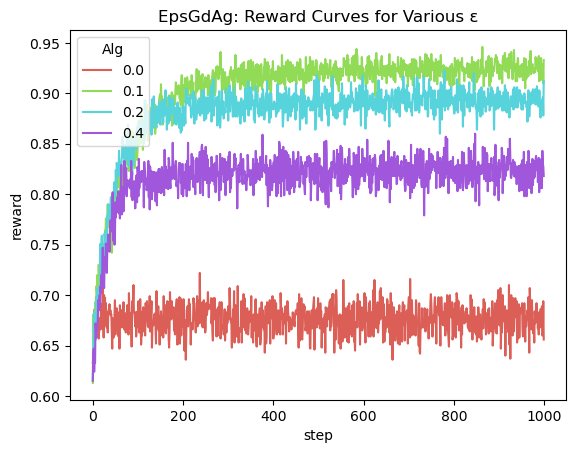

In [43]:
# TODO: Plot reward curves for EpsGdAg with epsilons [0, 0.1, 0.2, 0.4] (Simple placeholder)
print("Running EpsGdAg experiments with various eps values... (Simple)")
eps_logs = []
agents = []
labels = []
for eps in [0, 0.1, 0.2, 0.4]:
    agents.append(EpsGdAg(n_act=len(p_arr), eps=eps))
    labels.append(eps)
EpsGd_logs = mab_swp(agents=agents, p_arr=p_arr, labels=labels, n_runs=1000, max_steps=1000)

plot_logs(EpsGd_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("EpsGdAg: Reward Curves for Various ε")
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** PUT YOUR ANSWER HERE :)

Higher ε curves show more fluctuation and lower steady-state rewards, showing the heavier exploration. Lower ε curves stabilize faster with higher average reward.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** PUT YOUR ANSWER HERE :)

In rapidly changing or uncertain environments, extra exploration can help avoid getting stuck on suboptimal arms, even at the cost of lower short-term rewards.

## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [47]:
# %% [code]
# Download the dataset (if not already downloaded)
# !wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt
!curl -o dataset.txt http://www.cs.columbia.edu/~jebara/6998/dataset.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 2098k    0 15109    0     0  24130      0  0:01:29 --:--:--  0:01:29 24213
 17 2098k   17  372k    0     0   239k      0  0:00:08  0:00:01  0:00:07  240k
 43 2098k   43  915k    0     0   349k      0  0:00:06  0:00:02  0:00:04  350k
 73 2098k   73 1552k    0     0   436k      0  0:00:04  0:00:03  0:00:01  437k
100 2098k  100 2098k    0     0   502k      0  0:00:04  0:00:04 --:--:--  502k


In [48]:
# TODO: Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
ctxData = np.loadtxt('dataset.txt')  # Placeholder
print("Dataset loaded (Simple version):", ctxData)

Dataset loaded (Simple version): [[ 2.  0.  5. ... 30.  4.  0.]
 [ 8.  0.  1. ...  0.  0. 10.]
 [ 5.  0.  3. ...  3.  0.  0.]
 ...
 [ 9.  1. 79. ...  0.  0.  0.]
 [ 4.  0. 29. ... 17.  0.  0.]
 [ 4.  0.  0. ...  0.  0. 12.]]


In [73]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act+1 == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [93]:
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        # TODO: Compute UCB for arm a given state (Simple placeholder)
        A_inv = np.linalg.inv(self.As[a])
        x = state.reshape(-1, 1)
        theta = A_inv @ self.bs[a]
        p = (theta.T @ x)[0, 0] + self.alpha * np.sqrt(x.T @ A_inv @ x)[0, 0]  # Placeholder
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        # TODO: Update A and b for arm a (Simple placeholder)
        x = state.reshape(-1, 1)
        self.As[a] += x @ x.T
        self.bs[a] += rew * x


    def get_action(self, state):
        # TODO: Compute UCB estimates for all arms (Simple placeholder)
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        # TODO: Choose arm with highest UCB (Simple placeholder)
        max_ucb = max(p_est)
        arms = []
        for arm, p in enumerate(p_est):
            if p == max_ucb:
                arms.append(arm)

        sel_act = np.random.choice(arms)
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** PUT YOUR ANSWER HERE :)

LinUCB uses context features to estimate rewards with a linear model. This helps more generalization from the past expriences in similar contexts and often outperform classical methods that ignore contextual information.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** PUT YOUR ANSWER HERE :)

The α parameter scales the exploration bonus. A higher α increases the bonus and encourages more exploration of uncertain arms while lower α make the exploitation better.

In [94]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [95]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [99]:
# TODO: Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1 (Simple placeholder)
print("Running LinUCB sweep (Simple version)...")
logs_ctx = ctxBnd_swp(alphas=[0, 0.01, 0.1, 0.5], data=ctxData, n_runs=1)  # Placeholder

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Temp\ipykernel_23568\207309430.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


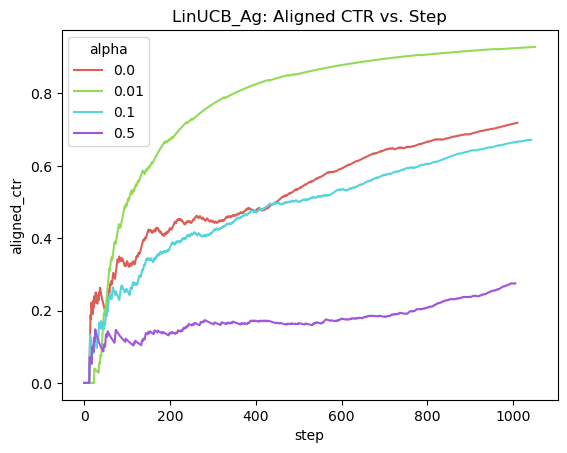

In [100]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** PUT YOUR ANSWER HERE :)

It scales the exploration bonus, so it controls how aggressively the agent explores uncertain arms.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** PUT YOUR ANSWER HERE :)

higher α curves show more exploration, while lower α curves converge faster but risk less exploration.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** PUT YOUR ANSWER HERE :)

LinUCB can outperform standard UCB if meaningful context is available, and here it works a little better.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** PUT YOUR ANSWER HERE :)


LinUCB Needs good feature representation; can be more complex.

UCB is Simpler but ignores context.

If context matters and you can model it, LinUCB is often better but if not, UCB is a good default.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

Altough UCB is optimal in the long run, its high exploration bonus early on delays exploitation and results in high regret over a small finit horizon. we should Balance aggressive early exploration with cautious long-term learning.
Since UCB's bonus tuned for asymptotic behavior, even when the best arm is evident it forces extra sampling and means delaying the exploitation and higher early regret while too little exploration risks missing the optimal arm.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.

Small mismatches in parameters can cause under/over exploration missing the best arm or wasting pulls. a self adaptie mechanism would adjust these based on performance.(for example reward variance)
A meta-algorithm could monitor metrics like reward stability or Q-value variance to weak exploration dynamically.

## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

The linear assumption in LinUCB may estimate rewards bad if the true relationship is nonlinear or the context is high-dimensional and noisy, potentially leading to overfitting. In these cases a contex-free UCB might perform better.
When many context features are irrelevant or noisy, the linear model can mislead especially with limited data. Dimensionality reduction or regularization can also helps.

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.

signals like high reward variance, unstable Q‑values, or sudden drops in performance can show switching between explore-first and UCB might be beneficial. a meta‑strategy can capture early transient improvements while having the long-term optimality.
By monitoring performance indicators, the agent can determine when enough exploration has occured. changing the strategies when estimates stabilize can combine the quick gains of explore-first with UCB's robust long-term learning.

## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

A forgetting mechanism lets agent discount old data to quickly to adapt to changing rewards, but choosing the decay rate is challenging because if it is too fast loses valuable info and if it is too slow hampers adaptation.
The decay must balance retaining useful history and reacting to new trends, an aggressive decay can make the agent chase noisr and a conservative decay may not reflect changes and this misguides the exploration bonus.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.

A high bonus forces contiued sampling of arms even when the optimal arm is found so this delays the convergence, and a less conservative bonus might accelerate learning in clear-cut cases, this risks permaturely dismissing promising arms.
The bonus must balance the need for theoritical guarantees with preactical efficiency. If it is too high it make the exploration too long and if it is low the early misestimation can cause the best arm to be overlooked.

## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.

A short exploration phase might miss the best arm and results in high regret, while a long phase delays exploitation reduces short‑term rewards. The optimal duration depends on reward variance and arm gaps.
In the environments with small differences between arms, too short exploration phase can lock in a suboptimal arm but in the cases that best arm is clear, extending exploration is unnecessary and increases regret by delaying exploitation.

## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.

Bayesian methods leverage prior knowledge and update beliefs, this can cause acceleration in learning if the priors are good, while frequentist methods rely just on the data, and when the prior is accurate the Bayesian performs better.
However, mis-specified priors can bias Bayesian method and the bayesian framework naturally adjusts exploration as more data is gathered, whereas UCB maintains a fixed exploration bonus based on count of each observation.

## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.

In skewed environments, high variance can cause UCB or ExpFstAg to misjudge arms beacuse of underestimating the best arm due to early noise and leading inconsistent exploitation.
Rarely high rewards might be missed or misinterpreted and causes the algorithms to allocate pulls inefficiently. The variability can mask the true performance gap so this makes it harder to consistently exploit the best arm.

##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

In high dimensional contexts with few informative features, LinUCB’s linear model risks overfitting noise so techniques like feature selection, regularization or non-linear approximations can improve performance but this addds complexity and computational cost.
The trade-off is betwen model simplicty and capturing complex relationships. Overfitting increases variance and hurts performance while aggresive dimensionality reduction might discard useful signals.